<a href="https://colab.research.google.com/github/danirofianto/tutorial/blob/master/freshfood.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("raghavrpotdar/fresh-and-stale-images-of-fruits-and-vegetables")

print("Path to dataset files:", path)

100%|██████████| 1.41G/1.41G [00:12<00:00, 116MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/raghavrpotdar/fresh-and-stale-images-of-fruits-and-vegetables/versions/1


In [ ]:
import shutil
import os

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Path hasil download (output dari kagglehub)
src_path = path

# Path tujuan di Google Drive
dst_path = "/content/drive/MyDrive/PENELITIAN2025/dataset"

# Buat folder tujuan kalau belum ada
os.makedirs(dst_path, exist_ok=True)

# Copy semua isi dataset ke Google Drive
shutil.copytree(src_path, dst_path, dirs_exist_ok=True)

print(f"✅ Dataset berhasil disalin ke: {dst_path}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
import os
import random

# path ke salah satu kelas dataset Anda (misal fresh_apple)
dataset_path = "dataset/fresh_apple"
img_name = random.choice(os.listdir(dataset_path))
img_path = os.path.join(dataset_path, img_name)

# load gambar asli
img = cv2.imread(img_path)[:,:,::-1]  # BGR -> RGB
img = cv2.resize(img, (256,256))

# definisi augmentasi (keras preprocessing)
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomTranslation(0.1,0.1),
    tf.keras.layers.RandomContrast(0.2),
])

# buat batch dummy agar bisa diproses keras
img_batch = tf.expand_dims(img, 0)

# tampilkan gambar asli + beberapa augmentasi
plt.figure(figsize=(12,6))
plt.subplot(2,4,1)
plt.imshow(img)
plt.title("Asli")
plt.axis("off")

for i in range(2,9):
    augmented = data_augmentation(img_batch)
    plt.subplot(2,4,i)
    plt.imshow(augmented[0].numpy().astype("uint8"))
    plt.title(f"Aug {i-1}")
    plt.axis("off")

plt.suptitle("Contoh Augmentasi Citra Dataset Pangan Lokal", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import EfficientNetB0, EfficientNetV2B0
from tensorflow.keras import layers, models, optimizers, Model
from tensorflow.keras.callbacks import ReduceLROnPlateau
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.metrics import confusion_matrix, classification_report
import os
import random

In [ ]:
IMG_SIZE = (256, 256)
BATCH_SIZE = 32
SEED = 1337

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dst_path,                 # ganti dengan folder dataset kamu
    validation_split=0.2,
    subset="training",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dst_path,
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)

CLASS_NAMES = train_ds.class_names
NUM_CLASSES = len(CLASS_NAMES)

print("Kelas:", CLASS_NAMES)


Found 9730 files belonging to 8 classes.
Using 7784 files for training.
Found 9730 files belonging to 8 classes.
Using 1946 files for validation.
Kelas: ['fresh_apple', 'fresh_banana', 'fresh_bitter_gourd', 'fresh_tomato', 'stale_apple', 'stale_banana', 'stale_bitter_gourd', 'stale_tomato']


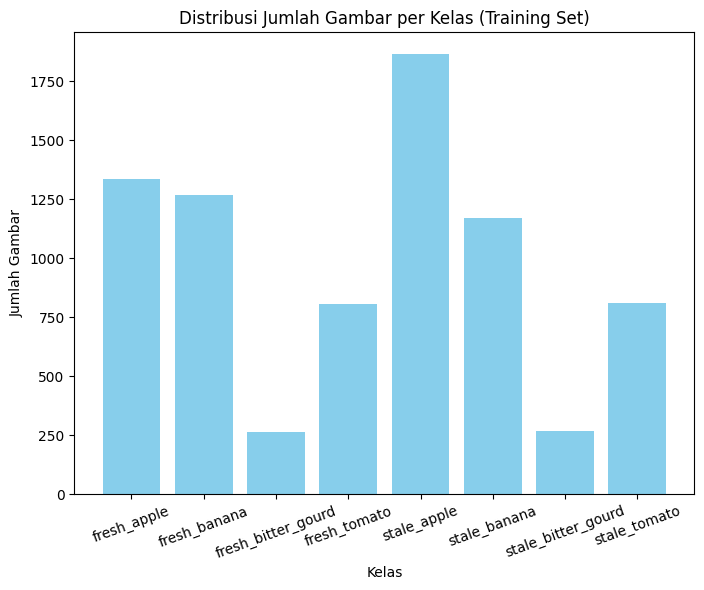

Jumlah per kelas:
fresh_apple: 1337
fresh_banana: 1267
fresh_bitter_gourd: 264
fresh_tomato: 806
stale_apple: 1866
stale_banana: 1169
stale_bitter_gourd: 267
stale_tomato: 808


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

all_labels = []
for _, labels in train_ds.unbatch():
    idx = np.argmax(labels.numpy())  # categorical → ambil index kelas
    all_labels.append(idx)

class_counts = Counter(all_labels)

plt.figure(figsize=(8,6))
plt.bar(CLASS_NAMES, [class_counts[i] for i in range(len(CLASS_NAMES))], color="skyblue")
plt.title("Distribusi Jumlah Gambar per Kelas (Training Set)")
plt.xlabel("Kelas")
plt.ylabel("Jumlah Gambar")
plt.xticks(rotation=20)
plt.show()

print("Jumlah per kelas:")
for i, c in enumerate(CLASS_NAMES):
    print(f"{c}: {class_counts[i]}")


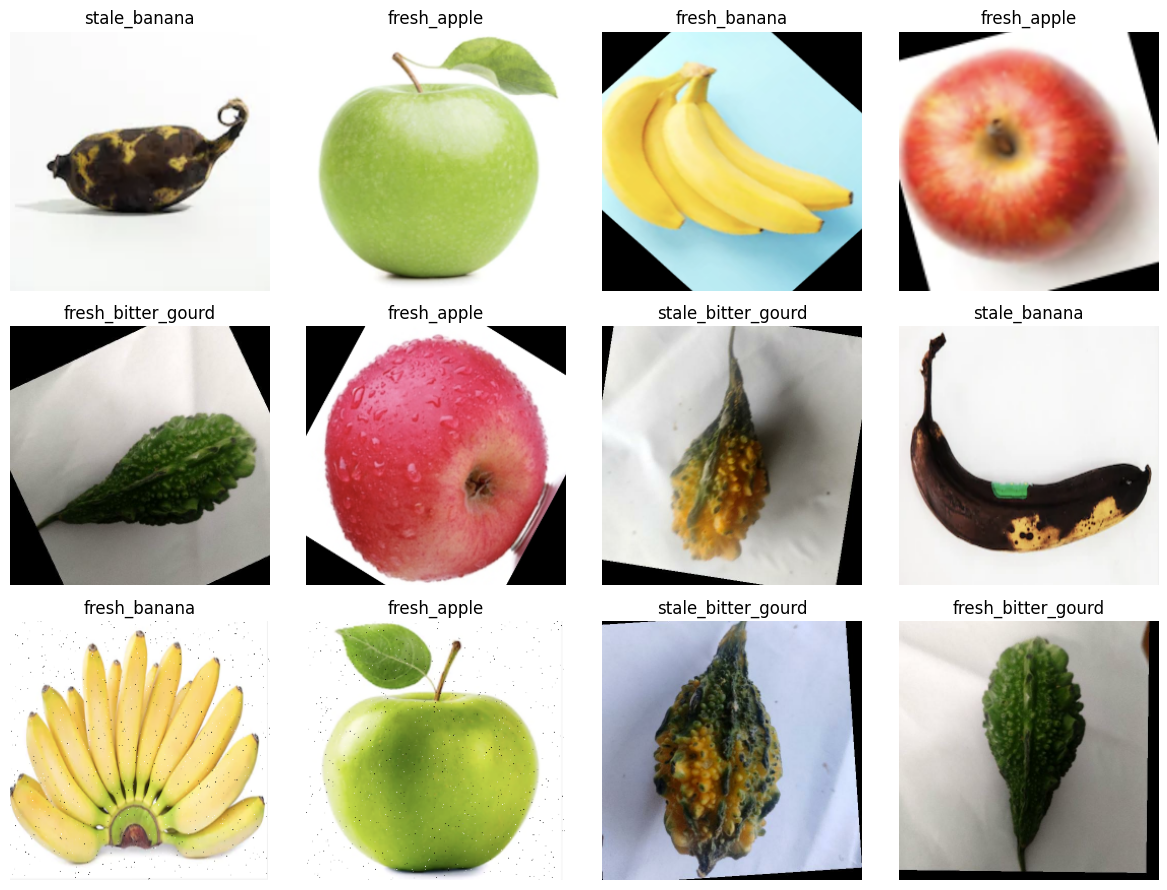

In [ ]:
import random

images, labels = next(iter(train_ds))
idxs = np.argmax(labels.numpy(), axis=1)

plt.figure(figsize=(12,9))
for i in range(12):
    plt.subplot(3, 4, i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(CLASS_NAMES[idxs[i]])
    plt.axis("off")
plt.tight_layout()
plt.show()


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input as effv2_preproc
from tensorflow.keras.applications.resnet import preprocess_input as resnet_preproc
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preproc

# --- pilih salah satu ---
preproc_fn = effv2_preproc   # ganti ke resnet_preproc atau mobilenet_preproc sesuai model
# ------------------------

DATA_DIR = dst_path if 'dst_path' in globals() else "/content/drive/MyDrive/PENELITIAN2025/dataset"
IMG_SIZE = (256, 256)
BATCH_SIZE = 32
SEED = 1337
VAL_SPLIT = 0.2

# TRAIN dengan augment + preprocessing_function
train_datagen = ImageDataGenerator(
    preprocessing_function=preproc_fn,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=VAL_SPLIT
)

# VAL hanya preprocessing_function (tanpa augment)
val_datagen = ImageDataGenerator(
    preprocessing_function=preproc_fn,
    validation_split=VAL_SPLIT
)

train_gen = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="training",
    seed=SEED,
    shuffle=True
)

val_gen = val_datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="validation",
    seed=SEED,
    shuffle=False
)

CLASS_NAMES = list(train_gen.class_indices.keys())
NUM_CLASSES = len(CLASS_NAMES)
print("Kelas & indeks:", train_gen.class_indices)
print("Jumlah batch (train/val):", len(train_gen), len(val_gen))


Found 7787 images belonging to 8 classes.
Found 1943 images belonging to 8 classes.
Kelas & indeks: {'fresh_apple': 0, 'fresh_banana': 1, 'fresh_bitter_gourd': 2, 'fresh_tomato': 3, 'stale_apple': 4, 'stale_banana': 5, 'stale_bitter_gourd': 6, 'stale_tomato': 7}
Jumlah batch (train/val): 244 61


3) Build & Compile EfficientNetV2B0 (Transfer Learning)

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetV2B0
# Jika kamu pakai Opsi B di Langkah 2, data sudah dipreprocess oleh generator.
# Jika Opsi A (rescale), kita bisa tetap masukkan layer preprocess identitas.

IMG_SIZE = (256, 256)
NUM_CLASSES = NUM_CLASSES  # sudah didefinisikan dari langkah 2
DROPOUT_RATE = 0.3
LABEL_SMOOTH = 0.05
LR_HEAD = 3e-4  # learning rate tahap-1 (head training)

# (1) Input
inp = layers.Input(shape=IMG_SIZE + (3,), name="input")

# (2) (Opsional) Preprocess layer:
# - Jika Opsi B (generator sudah preprocessing sesuai backbone), pakai lambda identitas.
# - Jika Opsi A (rescale), sebaiknya gunakan preprocess EfficientNetV2 di sini.
try:
    # coba deteksi apakah kita memakai Opsi B lewat variabel preproc_fn
    _ = preproc_fn  # jika variabel tidak ada, akan except
    x = layers.Lambda(lambda z: z, name="preprocess_identity")(inp)
except NameError:
    # fallback: Opsi A → gunakan preprocess EfficientNetV2
    from tensorflow.keras.applications.efficientnet_v2 import preprocess_input as effv2_preproc
    x = layers.Lambda(effv2_preproc, name="preprocess_effv2")(inp)

# (3) Backbone EfficientNetV2B0 (ImageNet, tanpa top)
base = EfficientNetV2B0(include_top=False, weights="imagenet", input_tensor=x)
for l in base.layers:
    l.trainable = False  # Tahap-1: freeze backbone

# (4) Head klasifikasi ringan dan kuat
y = layers.GlobalAveragePooling2D(name="gap")(base.output)
y = layers.Dropout(DROPOUT_RATE, name="dropout")(y)
out = layers.Dense(NUM_CLASSES, activation="softmax", dtype="float32", name="pred")(y)  # float32 utk mixed precision

model_effv2 = keras.Model(inp, out, name="EffNetV2B0_head")

# (5) Compile
loss = keras.losses.CategoricalCrossentropy(label_smoothing=LABEL_SMOOTH)
opt  = keras.optimizers.Adam(learning_rate=LR_HEAD)
model_effv2.compile(optimizer=opt, loss=loss, metrics=["accuracy"])

# (6) Ringkasan
model_effv2.summary()


Model: "EffNetV2B0_head"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)  │ (None, 256, 256,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ preprocess_identity │ (None, 256, 256,  │          0 │ input[0][0]       │
│ (Lambda)            │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 256, 256,  │          0 │ preprocess_ident… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_1     │ (None, 256, 256,  │          0 │ rescaling_1[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 128, 128,  │        864 │ normalization_1[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 128, 128,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 128, 128,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 128, 128,  │      4,608 │ stem_activation[… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 128, 128,  │         64 │ block1a_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, 128, 128,  │          0 │ block1a_project_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, 64, 64,    │      9,216 │ block1a_project_… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, 64, 64,    │        256 │ block2a_expand_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, 64, 64,    │          0 │ block2a_expand_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_co… │ (None, 64, 64,    │      2,048 │ block2a_expand_a… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_bn  │ (None, 64, 64,    │        128 │ block2a_project_… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_conv │ (None, 64, 64,    │     36,864 │ block2a_project_… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_bn   │ (None, 64, 64,    │        512 │ block2b_expand_c

 Total params: 5,929,560 (22.62 MB)

 Trainable params: 10,248 (40.03 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

4: Fine‑Tuning EfficientNetV2B0

In [ ]:
# Pastikan model_effv2 dari langkah 3 sudah ada
assert 'model_effv2' in globals(), "Model belum ada. Jalankan Langkah 3 dulu."

# Cari backbone (satu-satunya layer besar di dalam model_effv2)
backbone = None
for layer in model_effv2.layers:
    if isinstance(layer, keras.Model):   # backbone adalah submodel keras
        backbone = layer
        break

# kalau belum ketemu, coba dengan nama
if backbone is None:
    try:
        backbone = model_effv2.get_layer("efficientnetv2-b0")
    except:
        print("Nama layer backbone tidak cocok. Akan unfreeze semua.")
        backbone = model_effv2  # fallback → unfreeze semua

# Unfreeze top % dari backbone
UNFREEZE_PERCENT = 0.35
n_layers = len(backbone.layers)
start = int(n_layers * (1.0 - UNFREEZE_PERCENT))

for i, l in enumerate(backbone.layers):
    l.trainable = (i >= start)

print(f"Total backbone layers: {n_layers}")
print(f"Layers unfrozen (mulai index {start}): {sum([l.trainable for l in backbone.layers])}")

# Compile ulang dengan LR kecil
from tensorflow import keras
LR_FT = 1e-4
EPOCHS_FT = 5

steps_per_epoch = len(train_gen)
total_steps = steps_per_epoch * EPOCHS_FT
lr_sched = keras.optimizers.schedules.CosineDecay(LR_FT, decay_steps=total_steps)

opt_ft  = keras.optimizers.Adam(learning_rate=lr_sched)
loss_ft = keras.losses.CategoricalCrossentropy(label_smoothing=0.05)

model_effv2.compile(optimizer=opt_ft, loss=loss_ft, metrics=["accuracy"])

# Callback
ckpt_ft = keras.callbacks.ModelCheckpoint("EffNetV2B0_finetune.keras",
                                          monitor="val_accuracy", save_best_only=True, verbose=1)
early_ft = keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True)
reduce_ft = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-6)

# Training fine-tune
history_ft = model_effv2.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS_FT,
    callbacks=[ckpt_ft, early_ft, reduce_ft],
    verbose=1
)


Nama layer backbone tidak cocok. Akan unfreeze semua.
Total backbone layers: 274
Layers unfrozen (mulai index 178): 96
Epoch 1/5
244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7565 - loss: 1.0230
Epoch 1: val_accuracy improved from -inf to 0.99382, saving model to EffNetV2B0_finetune.keras
244/244 ━━━━━━━━━━━━━━━━━━━━ 1239s 5s/step - accuracy: 0.7571 - loss: 1.0213 - val_accuracy: 0.9938 - val_loss: 0.3022 - learning_rate: 9.0451e-05
Epoch 2/5
244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9802 - loss: 0.3351
Epoch 2: val_accuracy improved from 0.99382 to 0.99691, saving model to EffNetV2B0_finetune.keras
244/244 ━━━━━━━━━━━━━━━━━━━━ 1211s 5s/step - accuracy: 0.9802 - loss: 0.3351 - val_accuracy: 0.9969 - val_loss: 0.2851 - learning_rate: 6.5451e-05
Epoch 3/5
244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9904 - loss: 0.3092
Epoch 3: val_accuracy did not improve from 0.99691
244/244 ━━━━━━━━━━━━━━━━━━━━ 1207s 5s/step - accuracy: 0.9904 - loss: 0.3092 - val_accuracy

4.4 Model Performance: Accuracy, Errors & Insights

*   List item
*  4.4.1 Overall performance (train/val)



In [ ]:
import numpy as np

# Evaluasi cepat
train_loss, train_acc = model_effv2.evaluate(train_gen, verbose=0)
val_loss, val_acc     = model_effv2.evaluate(val_gen,   verbose=0)

print(f"Train  -> loss: {train_loss:.4f} | acc: {train_acc:.4f}")
print(f"Val    -> loss: {val_loss:.4f} | acc: {val_acc:.4f}")


Train  -> loss: 0.2765 | acc: 0.9988
Val    -> loss: 0.2803 | acc: 0.9974


                    precision    recall  f1-score   support

       fresh_apple     1.0000    1.0000    1.0000       338
      fresh_banana     1.0000    1.0000    1.0000       316
fresh_bitter_gourd     1.0000    1.0000    1.0000        65
      fresh_tomato     0.9751    1.0000    0.9874       196
       stale_apple     1.0000    1.0000    1.0000       468
      stale_banana     1.0000    1.0000    1.0000       293
stale_bitter_gourd     1.0000    1.0000    1.0000        71
      stale_tomato     1.0000    0.9745    0.9871       196

          accuracy                         0.9974      1943
         macro avg     0.9969    0.9968    0.9968      1943
      weighted avg     0.9975    0.9974    0.9974      1943



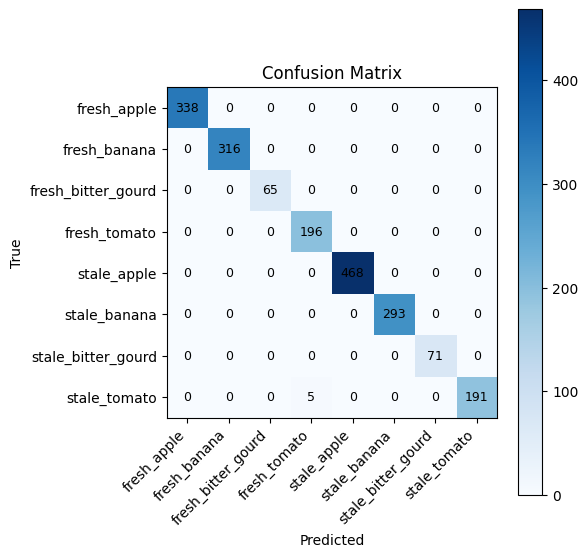

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# Kumpulkan prediksi di seluruh validation set
val_gen.reset()  # pastikan dari awal
y_prob = model_effv2.predict(val_gen, verbose=0)             # (N, C)
y_pred = np.argmax(y_prob, axis=1)                           # (N,)
y_true = val_gen.classes                                     # (N,)
class_names = CLASS_NAMES

# Laporan klasifikasi per kelas
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

# Confusion matrix (plot tanpa seaborn)
cm = confusion_matrix(y_true, y_pred)
fig, ax = plt.subplots(figsize=(6,6))
im = ax.imshow(cm, cmap='Blues')
ax.figure.colorbar(im, ax=ax)
ax.set_xticks(range(len(class_names)))
ax.set_yticks(range(len(class_names)))
ax.set_xticklabels(class_names, rotation=45, ha="right")
ax.set_yticklabels(class_names)
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_title("Confusion Matrix")
# anotasi angka
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i, j], ha="center", va="center", color="black", fontsize=9)
plt.tight_layout()
plt.show()


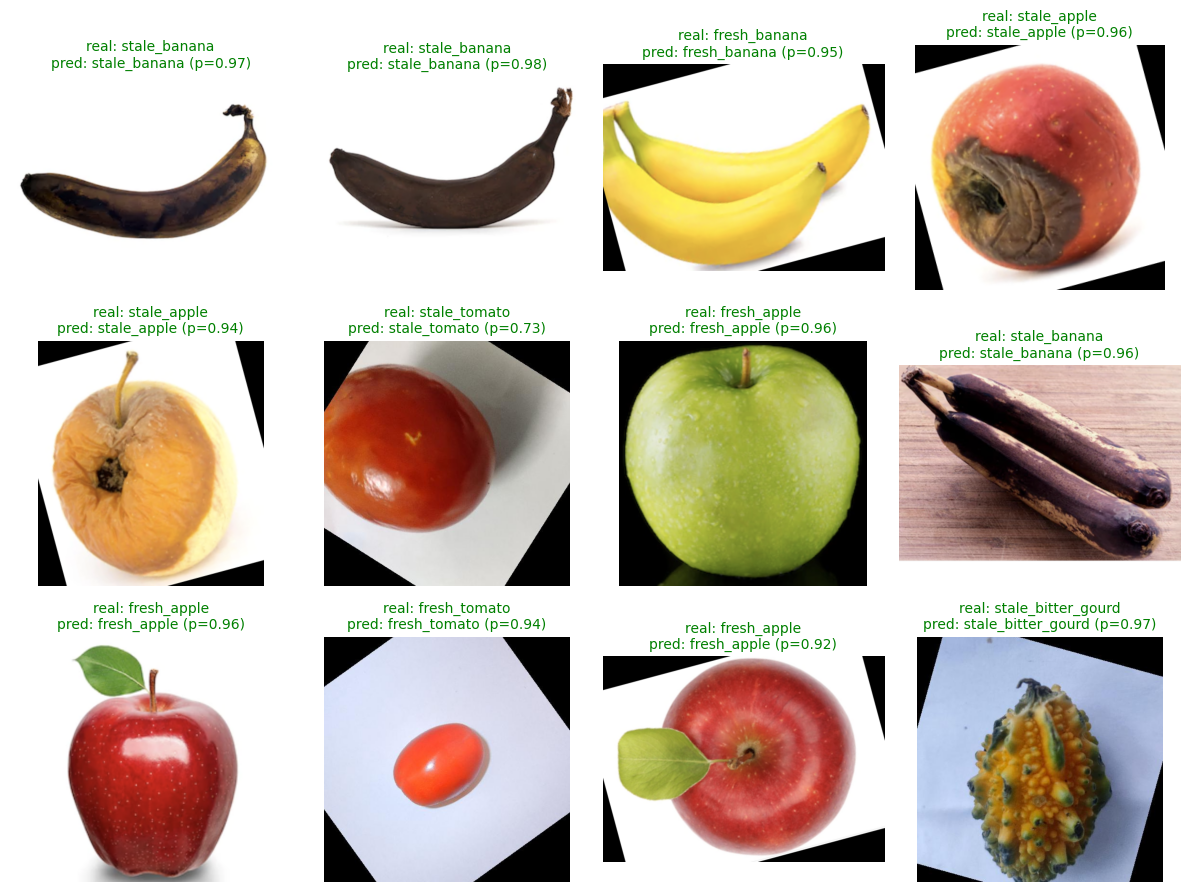

In [ ]:
import random
import matplotlib.pyplot as plt

# Ambil 12 indeks acak
N = len(y_true)
rand_idxs = random.sample(range(N), k=min(12, N))

plt.figure(figsize=(12,9))
for i, idx in enumerate(rand_idxs):
    img = plt.imread(val_gen.filepaths[idx])  # baca ulang gambar dari path
    true_lbl = class_names[y_true[idx]]
    pred_lbl = class_names[y_pred[idx]]
    prob = float(y_prob[idx, y_pred[idx]])

    ax = plt.subplot(3, 4, i+1)
    plt.imshow(img)
    plt.axis("off")
    title = f"real: {true_lbl}\npred: {pred_lbl} (p={prob:.2f})"
    ax.set_title(title, fontsize=10, color=("green" if true_lbl==pred_lbl else "red"))
plt.tight_layout()
plt.show()


Langkah 4.5: Plot learning curves

✅ Plot selesai untuk: Accuracy, Loss


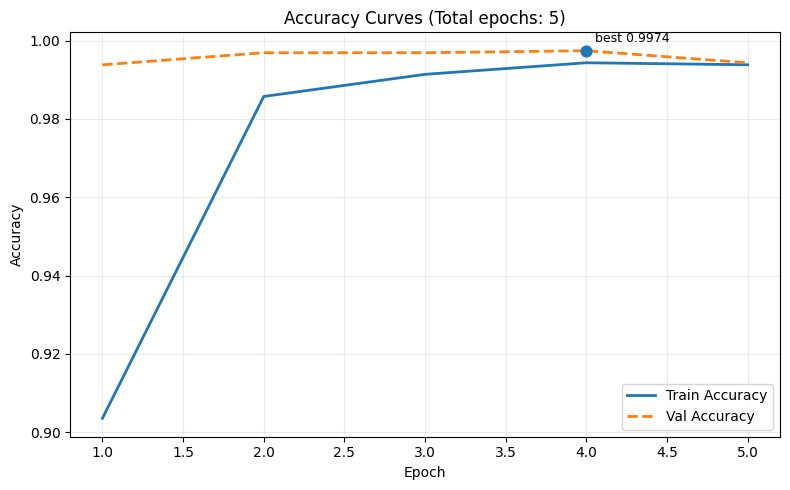

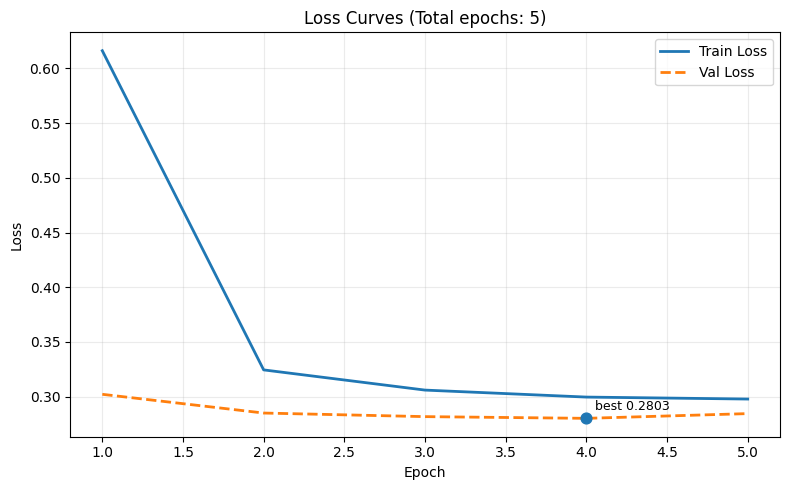

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def _extract(history):
    """Ambil dict metric dari History Keras → kembalikan dict {metric: list}"""
    if history is None:
        return {}
    if hasattr(history, 'history'):
        return history.history
    return history  # jika sudah berupa dict

# Ambil metrics dari history_head & history_ft (jika ada)
hist_head = _extract(globals().get('history_head', None))
hist_ft   = _extract(globals().get('history_ft',   None))

# Gabungkan head→ft untuk metric yang sama
def concat_metrics(h1, h2, key):
    a = h1.get(key, [])
    b = h2.get(key, [])
    return list(a) + list(b)

metrics_to_plot = [
    ("accuracy", "val_accuracy", "Accuracy"),
    ("loss",     "val_loss",     "Loss")
]

epochs_head = len(hist_head.get("loss", []))
epochs_ft   = len(hist_ft.get("loss", []))
total_epochs = epochs_head + epochs_ft

figs = []
for m_train, m_val, title in metrics_to_plot:
    y_tr = concat_metrics(hist_head, hist_ft, m_train)
    y_va = concat_metrics(hist_head, hist_ft, m_val)

    if len(y_tr) == 0 and len(y_va) == 0:
        print(f"⚠️ Tidak ada data untuk {title}. Melewati plot ini.")
        continue

    x = np.arange(1, max(len(y_tr), len(y_va)) + 1)

    plt.figure(figsize=(8,5))
    plt.plot(x, y_tr, label=f"Train {title}", linewidth=2)
    plt.plot(x, y_va, label=f"Val {title}", linewidth=2, linestyle="--")

    # Garis pemisah antara head→fine‑tune (jika keduanya ada)
    if epochs_head > 0 and epochs_ft > 0:
        plt.axvline(epochs_head, color="gray", linestyle=":", linewidth=1)
        plt.text(epochs_head+0.1, plt.ylim()[1]*0.95, "start FT", fontsize=9, color="gray")

    # Tandai best val point
    if len(y_va) > 0:
        if "Acc" in title or "acc" in m_val:
            best_idx = int(np.argmax(y_va))
        else:
            best_idx = int(np.argmin(y_va))
        plt.scatter(best_idx+1, y_va[best_idx], s=60, zorder=5)
        plt.annotate(f"best {y_va[best_idx]:.4f}", (best_idx+1, y_va[best_idx]),
                     textcoords="offset points", xytext=(6,6), fontsize=9)

    plt.title(f"{title} Curves (Total epochs: {total_epochs})")
    plt.xlabel("Epoch")
    plt.ylabel(title)
    plt.grid(True, alpha=0.25)
    plt.legend()
    plt.tight_layout()
    figs.append(title)

if figs:
    print("✅ Plot selesai untuk:", ", ".join(figs))
else:
    print("⚠️ Tidak ada plot yang dihasilkan. Pastikan history_head / history_ft tersedia.")
